In [27]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from transformers import BertModel, DistilBertModel
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datasets
import numpy as np
import data
import os.path
from datasets import load_from_disk
import pickle as pkl
from sklearn.linear_model import LogisticRegressionCV
from collections import defaultdict
from copy import deepcopy
from tqdm import tqdm
import dvu
dvu.set_style()
import pandas as pd
import config
from os.path import join as oj
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
rs = data.load_fitted_results()

dsets ['emotion', 'financial_phrasebank', 'rotten_tomatoes', 'sst2', 'tweet_eval']


100%|██████████| 84/84 [01:18<00:00,  1.07it/s]


In [56]:
rs.to_pickle(oj(config.results_dir, 'fitted_results_aggregated.pkl'))

In [57]:
rs = pd.read_pickle(oj(config.results_dir, 'fitted_results_aggregated.pkl'))

# best models table

In [124]:
def rename_checkpoint(checkpoint):
    if '/' in checkpoint:
        return 'bert-finetuned'
    else:
        return checkpoint

rfull = rs[rs.subsample == -1]
ans = defaultdict(list)
ind_dsets = []
for k, group in rfull.groupby('dataset'):
    ind_dsets.append(k)
#     print(k, group)
    # gg = group.groupby('checkpoint')
#     gg[]
    # for kk, ggroup in gg:
    for kk in ['bert-finetuned', 'bert-base-uncased', 'countvectorizer', 'tfidfvectorizer']:
        kkr = rename_checkpoint(kk)
        checkpoints = group.checkpoint.apply(rename_checkpoint).values
        # print(kkr, checkpoints)
        # print(kkr, kkr in checkpoints)
        if kkr in checkpoints:
            gg = group[checkpoints == kkr]
            # print(kkr, gg)
            ans[kkr].append(gg['acc_val'].max())
        else:
            ans[kkr].append(np.nan)    
tab = pd.DataFrame.from_dict(ans).round(3)
tab.index = map(data.DSETS_RENAME_DICT.get, ind_dsets, ind_dsets)
tab.columns = map(data.COLUMNS_RENAME_DICT.get, tab.columns)
# tab.style.highlight_max(color = 'lightgreen', axis=1)
tab.insert(len(tab.columns) - 1, 'BERT', tab.pop('BERT'))
tab

,BERT finetuned,Bag of ngrams,TF-IDF,BERT
Emotion,0.896,0.888,0.892,0.586
Financial phrasebank,0.932,0.854,0.851,0.824
Rotten tomatoes,0.812,0.748,0.763,0.780
SST2,0.877,0.823,0.837,0.813
Tweet (Hate),0.715,0.740,0.723,0.720


In [126]:
def bold_extreme_values(data):
    format_string="%.2f"
    max_=True
    if max_:
        extrema = data != data.max()
    else:
        extrema = data != data.min()
    bolded = data.apply(lambda x : "\\textbf{%s}" % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(extrema, bolded) 

tab2 = tab.apply(bold_extreme_values, axis=1)
print(tab2.to_latex(escape=False).replace('BERT finetuned', '\textbf{BERT finetuned}'))

\begin{tabular}{lllll}
\toprule
{} & BERT finetuned &  Bag of ngrams & TF-IDF &  BERT \\
\midrule
Emotion              &  \textbf{0.90} &           0.89 &   0.89 &  0.59 \\
Financial phrasebank &  \textbf{0.93} &           0.85 &   0.85 &  0.82 \\
Rotten tomatoes      &  \textbf{0.81} &           0.75 &   0.76 &  0.78 \\
SST2                 &  \textbf{0.88} &           0.82 &   0.84 &  0.81 \\
Tweet (Hate)         &           0.71 &  \textbf{0.74} &   0.72 &  0.72 \\
\bottomrule
\end{tabular}



# all curves

In [ ]:
for dset in ['financial_phrasebank', 'rotten_tomatoes', 'sst2']: # rs.dataset.unique():
    r = rs[rs.dataset == dset]

    R = 1
    C = 3
    plt.figure(figsize=(12, 5))
    # plt.figure(figsize=(8, 12))
    for i, subsample in enumerate([100, 1000, -1]):
        plt.subplot(R, C, i + 1)
        plt.title('Num train=' + str(subsample))
        d = r[r.subsample == subsample]

        curve = sorted(d.groupby(['checkpoint', 'all', 'norm']),
                       key=lambda x: data.COLUMNS_RENAME_DICT.get(x[0][0], 'BERT finetuned'))
        curve.append(curve.pop(0)) # move BERT to bottom
        for key, group in curve:
            g = group.sort_values('ngrams')
            label = data.COLUMNS_RENAME_DICT.get(key[0], 'BERT finetuned')
            if label == 'BERT finetuned':
                plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=2, color='black')
            else:
                plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=1)
        plt.ylabel(f'Accuracy ({data.DSETS_RENAME_DICT.get(dset)})')
        plt.xlabel('N-gram size')
        plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
    plt.savefig(f'results/acc_by_ngrams_{dset}.pdf')
#     plt.show()    
    #     print(curve)

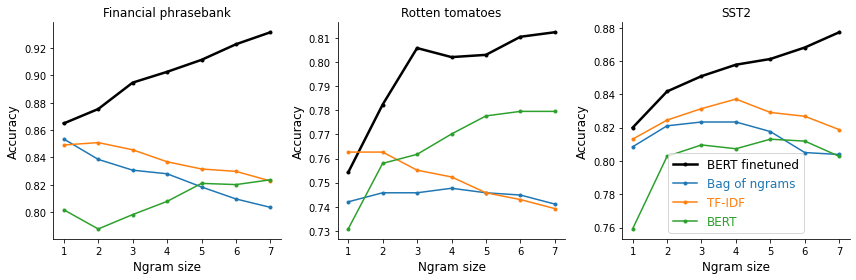

In [117]:
plt.figure(figsize=(12, 4))
for i, dset in enumerate(['financial_phrasebank', 'rotten_tomatoes', 'sst2']):
    r = rs[rs.dataset == dset]
    plt.subplot(1, 3, i + 1)
    plt.title(f'{data.DSETS_RENAME_DICT.get(dset)}', fontsize='large')
    d = r[r.subsample == subsample]

    curve = sorted(d.groupby(['checkpoint', 'all', 'norm']),
                   key=lambda x: data.COLUMNS_RENAME_DICT.get(x[0][0], 'BERT finetuned'))
    curve.append(curve.pop(0)) # move BERT to bottom
    for key, group in curve:
        g = group.sort_values('ngrams')
        label = data.COLUMNS_RENAME_DICT.get(key[0], 'BERT finetuned')
        if label == 'BERT finetuned':
            plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=2.5, color='black')
        else:
            plt.plot(g.ngrams, g.acc_val, '.-', label=label, lw=1.5)
    plt.ylabel(f'Accuracy', fontsize='large')
    plt.xlabel('Ngram size', fontsize='large')
#     plt.legend()
#         dvu.line_legend(fontsize=12)

    plt.tight_layout()
plt.legend(labelcolor='linecolor', fontsize='large')
plt.savefig(f'results/acc_by_ngrams_full.pdf')
#     plt.show()    
    #     print(curve)